# Sparkify 项目

学员：陈勤 2020年3月28日

## 定义

### 项目概览
数字音乐服务公司（如网易云音乐、QQ音乐）通过网页、桌面应用和移动应用为用户提供在线音乐服务。用户使用服务过程中，会产生诸如听歌、添加歌单、交友、点击广告、升级VIP和注销等庞大的行为日志。此项目旨在通过抽取日志相关性特征来预测客户流失情况。

预测客户流失率是数据科学家和分析师在面向消费者的一类公司中经常遇到的一项具有挑战性的问题。还有，能用 Spark 高效处理大数据集是数据领域职位急需的一种能力。

完整的数据集大小为 12GB，通过分析完整数据集的子集（小数据集），使用Spark 集群的时候，把成果迁移到大数据集上。

### 问题概述
1.把大数据集加载到 Spark 上，并使用 Spark SQL 和 Spark 数据框来操作数据

2.对数据进行清理、整理

3.对数据进行探索性分析

4.提取相关性特征

5.在 Spark ML 中使用机器学习 API 来搭建和调整模型

### 衡量指标
流失用户相对于整体用户的基数非常小（类似于从信用卡用户中找出失信用户），使用F1分数作为优化指标。实现精度和召回率平衡的模型

# 加载和清洗数据

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

In [5]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.count()

286500

## 评估

使用 

**df.count()**

**df.select("`column`").dropDuplicates().sort("`column`").show()**

**df.dropna(how = "any", subset = ["`column`"]).count()**

等方法来观察数据,结果如下：

数据集共有286500条记录，包含的特征如下：

- `artist`:创作歌曲的艺术家名字，有**228108**条记录
- `auth`:记录登录状态,数据完整无缺失
- `firstName`:用户名,有**2278154**条记录
- `gender`:性别,有**2278154**条记录
- `itemInSession`:当前会话中id,数据完整无缺失
- `lastName`:用户姓,有**2278154**条记录
- `length`:歌曲长度,有**2228108**条记录
- `level`:区分用户付费还是免费，数据完整无缺失
- `location`:用户地理位置,有**2278154**条记录
- `method`:数据上行还是下行,数据完整无缺失
- `page`:用户访问的页面,数据完整无缺失
- `registration`:注册时间,有**2278154**条记录
- `sessionId`:会话id,数据完整无缺失
- `song`:歌曲名,有**2228108**条记录
- `status`:用户访问页面的http状态码,数据完整无缺失
- `ts`:日志流水时间,数据完整无缺失
- `userAgent`用户访问使用的浏览器信息,数据完整无缺失
- `userId`用户id,数据完整无缺失

从观测值来看，数据分为两个维度：

- 从获取到的用户信息来看，有2278154条记录，而userId数据又是完整的，意味着有userId是无效的
- 从获取到的歌曲信息来看，有228108条记录，这个是可以接受，毕竟用户不是每一次行为都是听歌

### 质量
- `userId`列没有空值，但存在**空字符串**,为无效的用户ID
- `auth`、`level`、`method`、`page`、`itemInSession`、`sessionId`、`status`、`ts`列没有空值，数据完整
- `userAgent`,`registration`,`location`,`firstName`,`lastName`,`gender`列数据存在缺失值，条数都为278154条
- `artist`、`song`、`length`存在缺失值，条数都为228108

### 清洗
- 清洗0：去除`userId`为空字符串的数据

In [6]:
df_clean = df.filter(df["userId"] != "")
df_clean.count()

278154

清洗完`userId`列为空值的数据后，数据条数与`userAgent`,`registration`,`location`,`firstName`,`lastName`,`gender`列一致了

`artist`、`song`、`length`为歌曲的播放信息，用户并非每个动作都是听歌，所以存在缺失值是可以接受的

# 探索性数据分析
观察用户访问页面有那些行为：

In [7]:
df_clean.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



使用 Cancellation Confirmation 事件来定义客户流失

In [85]:
df_clean.select("userId").filter("page = 'Cancellation Confirmation'").sort("userId").show(5)

+------+
|userId|
+------+
|100001|
|100003|
|100005|
|100006|
|100007|
+------+
only showing top 5 rows



### 定义客户流失

创建一列 `Churn` 作为模型的标签。使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。

In [7]:
# 定义客户流失标记函数 1 为流失 0 为存留
flag_cancelled_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# 创建列Churn 
df_clean = df_clean.withColumn("churn", flag_cancelled_event("page"))

日志的时间都是timestamp类型，通过转换格式来观察时间日期

In [8]:
# 创建提取年月日的函数
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%Y"), StringType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%m"), StringType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%d"), StringType())
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000, None).strftime("%H"), StringType())

In [9]:
# 拆分流水时间为年月日小时
df_clean = df_clean.withColumn("tsyear", get_year(df_clean.ts))
df_clean = df_clean.withColumn("tsmonth", get_month(df_clean.ts))
df_clean = df_clean.withColumn("tsday", get_day(df_clean.ts))
df_clean = df_clean.withColumn("tshour", get_hour(df_clean.ts))

观察一个流失用户的行为

In [11]:
df_clean.select(["userId", "tsyear", "tsmonth", "tsday", "tshour", "page", "level", "churn"]).filter(df_clean.userId == "100001").sort(desc("ts")).collect()

[Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Cancellation Confirmation', level='free', churn=1),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Cancel', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Roll Advert', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Home', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='Logout', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', tshour='16', page='NextSong', level='free', churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', t

### 探索数据
从观察数据中来看，每一条日志记录了用户的一个动作，我决定采用page特征做为最主要的探索对象，将page中的重要动作提取出来进行独热编码

In [10]:
# 定义标记用户交友的函数
flag_frenid_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
# 创建列friend
df_clean = df_clean.withColumn("friend", flag_frenid_event("page"))

# 定义标记用户添加歌单的动作
flag_addplaylist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
# 创建列addplaylist
df_clean = df_clean.withColumn("addplaylist", flag_addplaylist_event("page"))

# 定义标记用户注销动作
flag_cancel_event = udf(lambda x: 1 if x == "Cancel" else 0, IntegerType())
# 创建列cancel
df_clean = df_clean.withColumn("cancel", flag_cancel_event("page"))

# 定义客户有降级动作的函数
flag_downgrade_action = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("downgrade", flag_downgrade_action("page"))

# 定义标记用户访问错误的动作
flag_error_event = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
# 创建列error
df_clean = df_clean.withColumn("error", flag_error_event("page"))

# 定义标记用户点击帮助的动作
flag_help_event = udf(lambda x: 1 if x == "Help" else 0, IntegerType())
# 创建列error
df_clean = df_clean.withColumn("help", flag_help_event("page"))

# 定义用户登出的函数
flag_logout_event = udf(lambda x: 1 if x == "Logout" else 0, IntegerType())
# 创建列logout
df_clean = df_clean.withColumn("logout", flag_logout_event("page"))

# 定义标记用户听歌的函数
flag_song_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
# 创建列song
df_clean = df_clean.withColumn("song", flag_song_event("page"))

# 定义标记用户升级动作的函数
flag_upgrade_action = udf(lambda x: 1 if x == "Upgrade" else 0, IntegerType())
# 创建列upgrade
df_clean = df_clean.withColumn("upgrade", flag_upgrade_action("page"))

# 定义标记用户升级的函数
flag_upgrade_event = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
# 创建列upgraded
df_clean = df_clean.withColumn("upgraded", flag_upgrade_event("page"))

# 定义标记客户降级的函数
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# 创建列downgraded
df_clean = df_clean.withColumn("downgraded", flag_downgrade_event("page"))

# 定义标记客户滚动广告的函数
flag_advert_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
# 创建列dadvert
df_clean = df_clean.withColumn("advert", flag_advert_event("page"))

# 定义收费免费标志
flag_level_event = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_clean = df_clean.withColumn("lv", flag_level_event("level"))


编码完成后，增加了12个特征，并进行了独热编码：

1.`friend`:用户的交友行为

2.`addplaylist`:用户添加歌单的行为

3.`cancel`:用户想要注销的行为

4.`downgrade`:用户想要降级的行为

5.`error`:用户访问发生错误的行为

6.`help`:用户访问帮助页面的行为

7.`logout`:用户登出的行为

8.`upgrade`:用户想要升级的行为

9.`upgraded`:用户确定升级的事件

10.`downgraded`:用户确定降级的事件

11.`advert`:用户点击广告的行为

12.`lv`:标识用户付费还是免费

按用户分组，汇总所有的行为和事件，在此过程中，发现听歌的事件在数量级上远大于其他事件，决定废弃听歌事件，以免对其他特征干扰太大

In [11]:
df_clean.createOrReplaceTempView("user_log_table")

In [12]:
# 将用户的动作汇总
user_acts = spark.sql('''SELECT  userId, 
                                 lv,
                                 sum(churn) as churn,
                                 sum(friend) as friend,
                                 sum(addplaylist) as addplaylist,
                                 sum(cancel) as cancel,
                                 sum(downgrade) as downgrade,
                                 sum(error) as error,
                                 sum(help) as help,
                                 sum(logout) as logout,
                                 sum(advert) as advert,
                                 sum(upgrade) as upgrade,
                                 sum(upgraded) as upgraded,
                                 sum(downgraded) as downgraded
                           from  user_log_table
                       group by  userId, lv ''')

In [13]:
pd_user_acts = user_acts.toPandas()

In [51]:
pd_user_acts.head()

,userId,lv,churn,friend,addplaylist,cancel,downgrade,error,help,logout,advert,upgrade,upgraded,downgraded
0,73,0,0,0,0,0,0,0,0,0,0,1,1,0
1,69,1,0,10,32,0,9,4,7,10,1,0,0,0
2,37,1,0,21,35,0,13,3,2,12,1,0,0,0
3,139,1,0,6,9,0,9,1,1,5,0,0,0,0
4,300007,1,1,4,4,1,2,0,1,0,2,0,0,0


#### 探索免费用户的行为

In [56]:
user_acts_sub = pd_user_acts[pd_user_acts.lv == 0].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

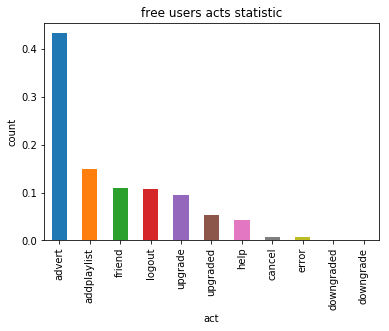

In [57]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("free users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

#### 探索免费流失用户的行为

In [58]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 0) & (pd_user_acts.churn == 1)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

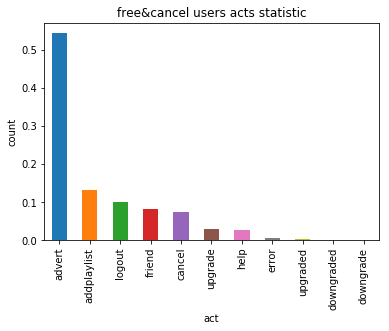

In [60]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("free&cancel users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从免费用户的统计图表来看：
- 广告点击事件的占比远高于其他事件
- 流失客户交友的占比低于存留用户
- 流失客户想要注销的占比高于存留客户

#### 探索付费用户的行为

In [62]:
user_acts_sub = pd_user_acts[pd_user_acts.lv == 1].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)

Text(0,0.5,'count')

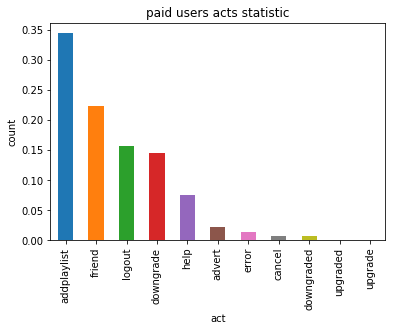

In [63]:
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

探索付费用户的统计图表，发现一个有意思的事，广告对用户的干扰占比很小，添加歌曲和交友占比变高起来

#### 探索付费用户降级的行为

Text(0,0.5,'count')

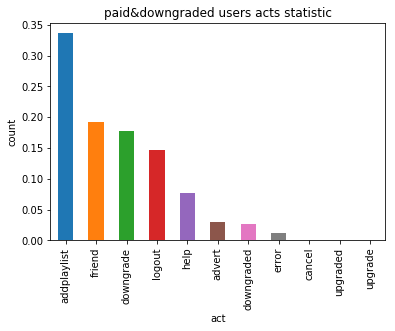

In [64]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 1) & (pd_user_acts.downgraded > 0)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&downgraded users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从付费用户发生降级行为的统计图表来看：
- 点击降级页面的占比高于整体付费用户水平
- 最终发生降低的占比高于整体付费用户水平

#### 探索付费用户流失的行为

Text(0,0.5,'count')

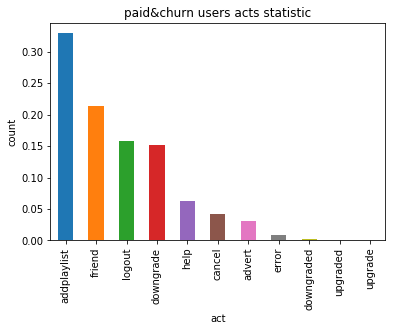

In [65]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 1) & (pd_user_acts.churn == 1)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&churn users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从付费用户最终流失的客户来看，想要降级和注销动作的占比高于整体付费用户水平

#### 探索用户升级的行为

Text(0,0.5,'count')

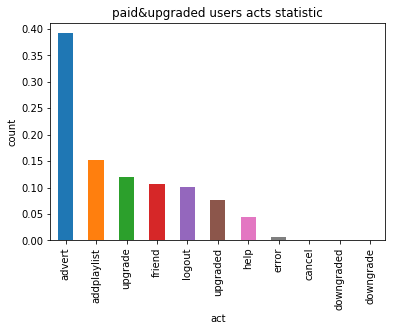

In [15]:
user_acts_sub = pd_user_acts[(pd_user_acts.lv == 0) & (pd_user_acts.upgraded > 0)].iloc[:,3:]
# 创建百分比
user_acts_sub = user_acts_sub.div(user_acts_sub.sum(axis=1), axis=0)
user_acts_sub.mean().sort_values(ascending = False).plot.bar()

plt.title("paid&upgraded users acts statistic")
plt.xlabel("act")
plt.ylabel("count")

从最终升级为付费用户的免费用户来看，想要升级的动作占比高较高

### 结论
- 广告是影响免费用户使用的一个关键特征
- 用户想要发生某种事件时，点击相关页面的占比比较高
- 添加歌单的行为在整体行为中占比高，我决定不使用其作为机器学习模型的特征

# 特征工程
最终选定做为机器学习特征如下：

1.`friend`:用户的交友行为

2.`cancel`:用户想要注销的行为

3.`downgrade`:用户想要降级的行为

4.`error`:用户访问发生错误的行为

5.`help`:用户访问帮助页面的行为

6.`upgrade`:用户想要升级的行为

7.`upgraded`:用户确定升级的事件

8.`advert`:用户点击广告的行为

9.`lv`:标识用户付费还是免费

除了`lv`特征保留1和0（1标识用户付费 0标识用户免费），其余特征按用户分组后，按时间顺序进行相加，做为关键特征的值

想要达到的效果如：2018年1月1日用户点击广告的日志，`adverts`特征计数为1，2018年1月2日用户点击广告的日志，`adverts`特征计数为2。其他特征也如此

处理完成后，对特征进行归一化，最终创建一个叫做`scaledfeatures2`的向量，用于机器学习

In [16]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# 创建列交友行为累计
df_clean = df_clean.withColumn("friends", Fsum("friend").over(windowval))


In [17]:
# 创建列广告点击行为累计
df_clean = df_clean.withColumn("adverts", Fsum("advert").over(windowval))

In [18]:
# 创建列降级动作累计
df_clean = df_clean.withColumn("downgrades", Fsum("downgrade").over(windowval))

In [19]:
# 创建列注销动作累计
df_clean = df_clean.withColumn("cancels", Fsum("cancel").over(windowval))

In [20]:
# 创建列升级动作累计
df_clean = df_clean.withColumn("upgrades", Fsum("upgrade").over(windowval))

In [21]:
# 创建列降级累计
df_clean = df_clean.withColumn("phase", Fsum("downgraded").over(windowval))

In [22]:
# 创建列帮助动作累计
df_clean = df_clean.withColumn("helps", Fsum("help").over(windowval))

In [23]:
# 创建列错误页累计
df_clean = df_clean.withColumn("errors", Fsum("error").over(windowval))

In [19]:
# 将关键特征转换为向量
assembler = VectorAssembler(inputCols=[ "lv", "friends", "adverts", "downgrades", "cancels", "upgrades", "helps", "errors" , "phase"], outputCol="features")
df_clean = assembler.transform(df_clean)

In [20]:
# 将向量进行归一化
scaler = Normalizer(inputCol="features", outputCol="scaledfeatures")
df_clean = scaler.transform(df_clean)

In [21]:
# 用标准差缩小值
scaler2 = StandardScaler(inputCol="scaledfeatures", outputCol="scaledfeatures2", withStd=True)
scalerModel = scaler2.fit(df_clean)
df_clean = scalerModel.transform(df_clean)

In [22]:
df_clean.select(["userId", "tsyear", "tsmonth", "tsday", "scaledfeatures2", "churn"]).filter(df_clean.userId == "100001").sort(desc("ts")).collect()

[Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.4998, 2.7777, 0.0, 22.3883, 1.4515, 0.486, 1.2227, 0.0]), churn=1),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.4998, 2.7777, 0.0, 22.3883, 1.4515, 0.486, 1.2227, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.501, 2.7845, 0.0, 0.0, 1.4551, 0.4872, 1.2257, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId='100001', tsyear='2018', tsmonth='10', tsday='02', scaledfeatures2=DenseVector([0.0, 0.5375, 2.7737, 0.0, 0.0, 1.5609, 0.5227, 1.3149, 0.0]), churn=0),
 Row(userId

从上面的数据片段可以看到，`scaledfeatures2`特征已创建完毕

# 建模

**最终需要解决的问题是一个二分类问题**

模型选择决定采用逻辑回归和决策树先进行尝试，如果预测效果不好，再选择其他模型

- 逻辑回归模型:调整的参数先尝试`regParam`，使用0和0.1进行网格搜索

- 决策树模型：调整的参数先尝试`maxDepth`，使用5和10进行网格搜索

流失用户相对于整体用户的基数非常小，使用F1分数作为优化指标。实现精度和召回率平衡的模型

操作步骤如下：

1.将完整数据集分成训练集、测试集和验证集

2.使用逻辑回归模型进行测试，得到f1分数和学习时间

3.使用决策树模型进行测试，得到f1分数和学习时间

4.比较两种模型的准确率，如果两种模型的f1分数低于0.9，尝试选择其他模型；如果效果较好，比较两个模型的学习效率

In [28]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col

In [29]:
data = df_clean.select(col("churn").alias("label"), col("scaledfeatures2").alias("features"))
data.head()

Row(label=0, features=SparseVector(9, {}))

In [30]:
rest, validation = data.randomSplit([0.9, 0.1], seed=42)

In [24]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier


In [47]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1]).build()

f1_score = MulticlassClassificationEvaluator(metricName = 'f1')


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)

In [48]:
cvModel_q1 = crossval.fit(rest)

In [49]:
results = cvModel_q1.transform(validation)

In [52]:
from time import time
# 查看结果
# 时间也是衡量模型好坏的一个标准
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("逻辑回归分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(results, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(results, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

逻辑回归分数:
准确度: 0.9997849231100119
f1分数: 0.9996773962307786
验证集计算准确度与f1分数用时 50.80810737609863秒


In [26]:

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder().addGrid(dt.maxDepth,[5, 10]).build()
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)

In [32]:
cvModel_q1 = crossval.fit(rest)
results = cvModel_q1.transform(validation)

In [33]:
from time import time
# 查看结果
# 时间也是衡量模型好坏的一个标准
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("决策树分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(results, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(results, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

决策树分数:
准确度: 0.9996773846650178
f1分数: 0.999623624117308
验证集计算准确度与f1分数用时 50.13434457778931秒


## 建模结论
1.逻辑回归模型的f1分数为0.9997，验证集预测时间用时50.8秒

2.决策树模型的f1分数为0.9996，验证集预测时间用时50.1秒

3.两个模型都非常棒，几乎没有差别，因此我决定使用逻辑回归做为本项目使用的最终模型